<a href="https://colab.research.google.com/github/dilip982/CNN/blob/main/Dilip_Singh_Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning Using Tensorflow Hub

 TensorFlow is an online repository of already trained TensorFlow models that we can use. These models can either be used as is, or they can be used for Transfer Learning.

Transfer learning is a process where we take an existing trained model, and extend it to do additional work. This involves leaving the bulk of the model unchanged, while adding and retraining the final layers, in order to get a different set of possible outputs.

# Concepts that will be covered in this Colab
- Use a TensorFlow Hub model for prediction.
- Use a TensorFlow Hub model for Dogs vs. Cats dataset.
- Do simple transfer learning with TensorFlow Hub.

# Importing Dependencies

In [2]:
import tensorflow as tf
import matplotlib.pylab as plt
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers


In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Part 1: Use a TensorFlow Hub MobileNet for prediction

In this segment, I'll take a trained model, load it into to Keras, and try it out.

The model that I'll use is MobileNet v2

# Download the classifier model

Download the MobileNet model and create a Keras model from it. MobileNet is expecting images of 224  ×  224 pixels, in 3 color channels (RGB).

In [4]:
classifier_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"

image_res = 224

model = tf.keras.Sequential([ hub.KerasLayer(classifier_url, 
                                              input_shape = (image_res, image_res, 3))
                             
])

# Test it for a Single Image

MobileNet has been trained on the ImageNet dataset. ImageNet has 1000 different output classes, and one of them is military uniforms. Let's get an image containing a military uniform that is not part of ImageNet, and see if our model can predict that it is a military uniform.

24576/15414 [===============================================] - 0s 0us/step


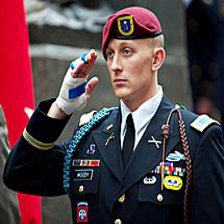

In [5]:
import numpy as np
import PIL.Image as Image

dress = tf.keras.utils.get_file('image.jpg','https://upload.wikimedia.org/wikipedia/commons/thumb/2/27/U.S._Army_1st_Lt._Alexander_Woody%2C_with_the_82nd_Airborne_Division%2C_stands_for_the_national_anthem_during_a_ceremony_celebrating_the_U.S._Army%27s_237th_birthday_in_Times_Square_June_14%2C_2012%2C_in_New_York_120614-A-AO884-084.jpg/215px-thumbnail.jpg' ) 
dress = Image.open(dress).resize((image_res,image_res))
dress

In [6]:
dress = np.array(dress)/255
dress.shape

(224, 224, 3)

Important Note: models always want a batch of images to process. So here, we add a batch dimension, and pass the image to the model for prediction.

In [7]:
result = model.predict(dress[np.newaxis, ...])
result.shape

(1, 1001)

The result is a 1001 element vector of logits, rating the probability of each class for the image.

So the top class ID can be found with argmax. But how can we know what class this actually is and in particular if that class ID in the ImageNet dataset denotes a military uniform or something else?

In [8]:
predicted_class = np.argmax(result[0], axis = -1)
predicted_class


653

# Decode the predictions

To see what our predicted_class is in the ImageNet dataset, download the ImageNet labels and fetch the row that the model predicted.

24576/10484 [======================================================================] - 0s 0us/step


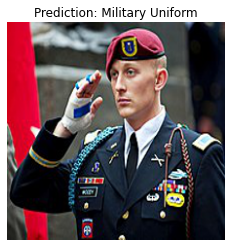

In [9]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(dress)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

# Part 2: Use a TensorFlow Hub models for the Cats vs. Dogs dataset

Now I'll use the full MobileNet model and see how it can perform on the Dogs vs. Cats dataset.

#Dataset

We can use TensorFlow Datasets to load the Dogs vs Cats dataset.

In [11]:
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True,
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete0SZLWF/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


The images in the Dogs vs. Cats dataset are not all the same size.

In [14]:
for i, image_example in enumerate(train_examples.take(3)):
  print(" Image {}  Shape: {}".format(i+1, image_example[0].shape))

 Image 1  Shape: (262, 350, 3)
 Image 2  Shape: (409, 336, 3)
 Image 3  Shape: (493, 500, 3)


So I  need to reformat all images to the resolution expected by MobileNet (224, 224).

In [25]:
def format_image(image,label):
  image = tf.image.resize(image,(image_res, image_res))/255.0
  return image,label

Batch_Size = 32

train_batches = train_examples.shuffle(num_examples//4).map(format_image).batch(Batch_Size).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(Batch_Size).prefetch(1)


# Run the classifier on a batch of images

Keeping in mind that our model object is still the full MobileNet model trained on ImageNet, so it has 1000 possible output classes. ImageNet has a lot of dogs and cats in it, so let's see if it can predict the images in our Dogs vs. Cats dataset.

In [17]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_name = imagenet_labels[np.argmax(result_batch, axis = -1)]

predicted_class_name

array(['colobus', 'Siamese cat', 'Walker hound', 'Leonberg', 'redbone',
       'lynx', 'affenpinscher', 'tiger cat', 'papillon', 'toy poodle',
       'beagle', 'beagle', 'tabby', 'Egyptian cat', 'Appenzeller',
       'tabby', 'Great Pyrenees', 'tiger cat', 'bloodhound',
       'breastplate', 'black-and-tan coonhound', 'lynx', 'Rottweiler',
       'tabby', 'flat-coated retriever', 'Persian cat', 'Persian cat',
       'Egyptian cat', 'Persian cat', 'Ibizan hound', 'dingo', 'whippet'],
      dtype='<U30')

The labels seem to match names of Dogs and Cats. Let's now plot the images from our Dogs vs Cats dataset and put the ImageNet labels next to them.

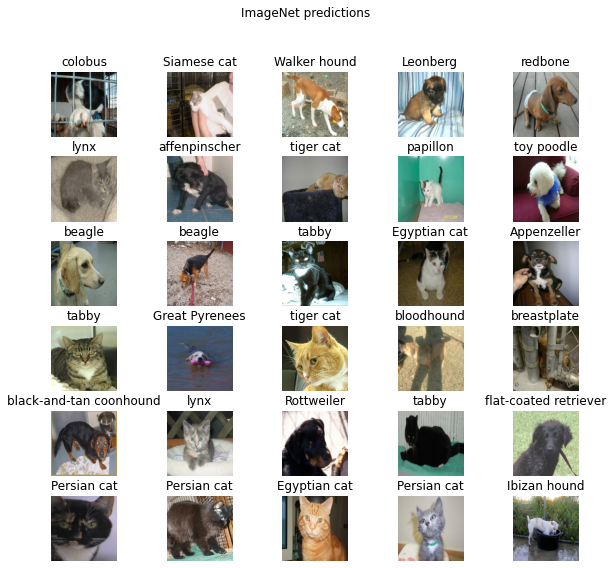

In [18]:
plt.figure(figsize =(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_name[n])
  plt.axis('off')

_ = plt.suptitle("ImageNet predictions")


# Part 3: Simple transfer learning with TensorFlow Hub

With transfer learning we can reuse parts of an already trained model and change the final layer, or several layers, of the model, and then retrain those layers on our own dataset.

In addition to complete models, TensorFlow Hub also distributes models without the last classification layer. These can be used to easily do transfer learning. I will continue using MobileNet v2.

I'll also continue to use the Dogs vs Cats dataset, so I will be able to compare the performance of this model against the ones I created from scratch earlier.

Note:  I am calling the partial model from TensorFlow Hub (without the final classification layer) a feature_extractor. The reasoning for this term is that it will take the input all the way to a layer containing a number of features. So it has done the bulk of the work in identifying the content of an image, except for creating the final probability distribution. That is, it has extracted the features of the image.


In [20]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"

feature_extractor = hub.KerasLayer(URL,
                                    input_shape = (image_res, image_res, 3))


Executing a batch of images through this, and checking the final shape. 32 is the number of images, and 1280 is the number of neurons in the last layer of the partial model from TensorFlow Hub.

In [21]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


# Most Important
Freeze the variables in the feature extractor layer, so that the training only modifies the final classifier layer.

In [22]:
feature_extractor.trainable = False

# Attach a classification model
Wrapping the hub layer in a tf.keras.Sequential model, and adding a new classification layer.

In [23]:
model = tf.keras.Sequential([feature_extractor,
                             layers.Dense(2)
                             ])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


# Train the model
Now I'll train this model like any other, by first calling compile followed by fit.

In [27]:
from matplotlib.dates import EPOCH_OFFSET
model.compile(optimizer = 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])
EPOCHS = 6

history = model.fit(train_batches,
                    epochs = EPOCHS,
                    validation_data = validation_batches
                    )

Epoch 1/6
582/582 [==============================] - 42s 60ms/step - loss: 0.0537 - accuracy: 0.9817 - val_loss: 0.0324 - val_accuracy: 0.9893
Epoch 2/6
582/582 [==============================] - 41s 64ms/step - loss: 0.0301 - accuracy: 0.9895 - val_loss: 0.0301 - val_accuracy: 0.9903
Epoch 3/6
582/582 [==============================] - 41s 64ms/step - loss: 0.0249 - accuracy: 0.9915 - val_loss: 0.0315 - val_accuracy: 0.9893
Epoch 4/6
582/582 [==============================] - 41s 64ms/step - loss: 0.0208 - accuracy: 0.9933 - val_loss: 0.0342 - val_accuracy: 0.9899
Epoch 5/6
582/582 [==============================] - 41s 64ms/step - loss: 0.0187 - accuracy: 0.9939 - val_loss: 0.0323 - val_accuracy: 0.9905
Epoch 6/6
582/582 [==============================] - 46s 71ms/step - loss: 0.0179 - accuracy: 0.9941 - val_loss: 0.0326 - val_accuracy: 0.9901


We can see I get ~99% validation accuracy, which is absolutely awesome. The main reason for this best performance is that MobileNet was carefully designed over a long time by experts, then trained on a massive dataset (ImageNet).


Let's plot the training and validation accuracy/loss graphs.

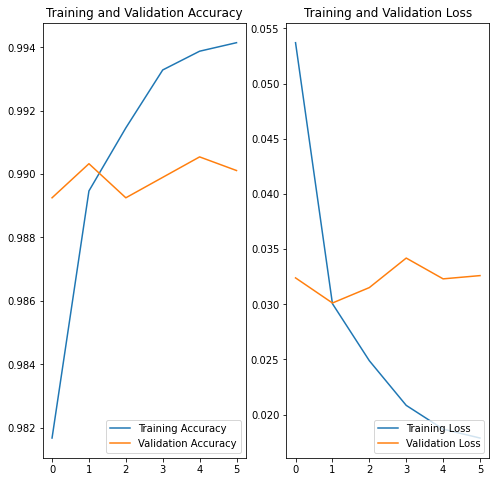

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label = "Training Accuracy")
plt.plot(epochs_range, val_acc, label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label = "Training Loss")
plt.plot(epochs_range, val_loss, label = "Validation Loss")
plt.legend(loc = 'lower right')
plt.title("Training and Validation Loss")

plt.show()




What is a bit curious here is that validation performance is better than training performance, right from the start to the end of execution.

One reason for this is that validation performance is measured at the end of the epoch, but training performance is the average values across the epoch.

The bigger reason though is that we're reusing a large part of MobileNet which is already trained on Dogs and Cats images. While doing training, the network is still performing image augmentation on the training images, but not on the validation dataset. This means the training images may be harder to classify compared to the normal images in the validation dataset.

# Check the predictions
To redo the plot from before, first get the ordered list of class names.

In [29]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

Run the image batch through the model and convert the indices to class names.

In [30]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['dog', 'cat', 'dog', 'dog', 'dog', 'cat', 'dog', 'cat', 'cat',
       'dog', 'dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'dog', 'cat',
       'dog', 'dog', 'dog', 'cat', 'dog', 'cat', 'dog', 'cat', 'cat',
       'cat', 'cat', 'dog', 'dog', 'dog'], dtype='<U3')

Let's look at the true labels and predicted ones.

In [31]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [1 0 1 1 1 0 1 0 0 1 1 1 0 0 1 0 1 0 1 1 1 0 1 0 1 0 0 0 0 1 1 0]
Predicted labels:  [1 0 1 1 1 0 1 0 0 1 1 1 0 0 1 0 1 0 1 1 1 0 1 0 1 0 0 0 0 1 1 1]


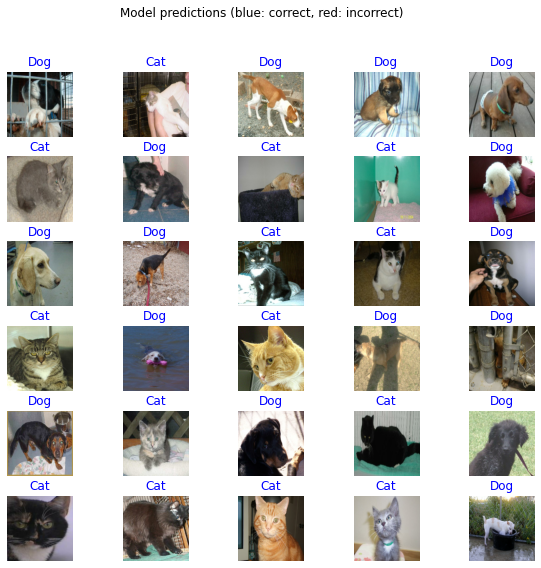

In [32]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")